In [1]:
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import cv2
import PIL 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential

In [2]:
main_path = pathlib.Path('C:/Users/sneha/OneDrive/Desktop/Data/dataset/')

# Total number of images

In [3]:
len(list(main_path.glob('*/*.jpg')))

2448

Making a dictionary containing all the different weather photos

In [4]:
weather_dict = {
    'lightning' : list(main_path.glob('lightning/*.jpg')),
    'rain' : list(main_path.glob('rain/*.jpg')),
    'rainbow' : list(main_path.glob('rainbow/*.jpg')),
    'sandstorm' : list(main_path.glob('sandstorm/*.jpg')),
    'snow' : list(main_path.glob('snow/*.jpg')),
}

In [5]:
weather_labels = {
    'lightning' : 0,
    'rain' : 1,
    'rainbow' : 2,
    'sandstorm' : 3,
    'snow' : 4,
}

# Checking an image

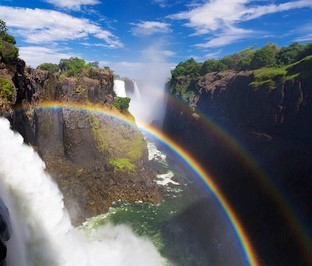

In [6]:
PIL.Image.open(str(list(main_path.glob('rainbow/*.jpg'))[15]))

In [7]:
X, y = [], []

# Reading the images

In [8]:
for weather_name, images in weather_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        try:
            resized = cv2.resize(img, (180,180))
            X.append(resized)
            y.append(weather_labels[weather_name])
        except:
            pass

In [9]:
X = np.array(X)
y = np.array(y)

# Splitting into train and test, then scaling the images

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 15, stratify = y)

In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [12]:
X_train.shape

(1639, 180, 180, 3)

In [13]:
X_test.shape

(808, 180, 180, 3)

In [14]:
pd.DataFrame(y_train).value_counts()

3    464
4    415
1    352
0    253
2    155
dtype: int64

# Training the CNN model

In [15]:
model = Sequential([
    layers.Conv2D(filters = 16, kernel_size = (3,3), input_shape = (180,180,3), activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(5, activation = 'sigmoid')
])

model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics = ['accuracy'])

model.fit(X_train_scaled, y_train, epochs = 20)

Epoch 1/20
52/52 [==============================] - 24s 455ms/step - loss: 1.3407 - accuracy: 0.5021
Epoch 2/20
52/52 [==============================] - 22s 414ms/step - loss: 1.1300 - accuracy: 0.7035
Epoch 3/20
52/52 [==============================] - 22s 424ms/step - loss: 1.0907 - accuracy: 0.7468
Epoch 4/20
52/52 [==============================] - 21s 413ms/step - loss: 1.0765 - accuracy: 0.7669
Epoch 5/20
52/52 [==============================] - 21s 410ms/step - loss: 1.0742 - accuracy: 0.7797
Epoch 6/20
52/52 [==============================] - 21s 402ms/step - loss: 1.0742 - accuracy: 0.7572
Epoch 7/20
52/52 [==============================] - 21s 396ms/step - loss: 1.0353 - accuracy: 0.8255
Epoch 8/20
52/52 [==============================] - 21s 401ms/step - loss: 1.0208 - accuracy: 0.8597
Epoch 9/20
52/52 [==============================] - 21s 399ms/step - loss: 1.0110 - accuracy: 0.8682
Epoch 10/20
52/52 [==============================] - 21s 398ms/step - loss: 0.9911 - accura

In [16]:
model.evaluate(X_test_scaled, y_test)

26/26 [==============================] - 4s 135ms/step - loss: 1.0597 - accuracy: 0.8453


[1.059664011001587, 0.8452970385551453]

Since there is not much difference between the accuracies of the test and train datasets, there is no need for data augmentation

# Making predictions 

In [17]:
predictions = model.predict(X_test_scaled)
predictions

array([[4.6400360e-06, 1.5577937e-06, 9.9999952e-01, 1.0115290e-06,
        1.3217237e-05],
       [9.9984735e-01, 8.7512944e-06, 1.1012910e-04, 1.0193307e-05,
        4.2134523e-04],
       [3.8316650e-12, 1.0000000e+00, 9.3413217e-07, 1.3186867e-07,
        2.7987067e-08],
       ...,
       [1.8618637e-08, 1.0000000e+00, 1.1643712e-12, 9.7066514e-16,
        4.2569975e-12],
       [1.0162499e-07, 8.1219355e-07, 1.0000000e+00, 4.0932005e-10,
        4.1651996e-10],
       [2.4710927e-09, 1.4813254e-14, 2.7973422e-18, 1.0000000e+00,
        2.7360324e-13]], dtype=float32)

In [18]:
prediction1 = [np.argmax(tf.nn.softmax(prediction)) for prediction in predictions]
prediction1[:5]

[2, 0, 1, 1, 1]

# Confusion Matrix

In [19]:
confusion_matrix(y_test, prediction1)

array([[109,   4,   4,   4,   3],
       [  4, 141,   2,   5,  22],
       [  3,   5,  53,  15,   1],
       [  1,   5,   5, 217,   0],
       [  2,  35,   1,   4, 163]], dtype=int64)

In [20]:
print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       124
           1       0.74      0.81      0.77       174
           2       0.82      0.69      0.75        77
           3       0.89      0.95      0.92       228
           4       0.86      0.80      0.83       205

    accuracy                           0.85       808
   macro avg       0.84      0.82      0.83       808
weighted avg       0.85      0.85      0.84       808



# Checking with unknown data 

In [21]:
img = cv2.imread('C:/Users/sneha/OneDrive/Desktop/photo.jpeg')

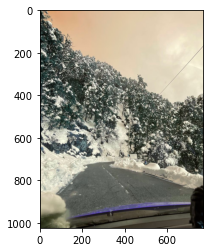

In [22]:
plt.imshow(img)

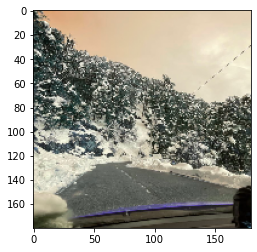

In [23]:
resized_image = cv2.resize(img, (180,180))
scaled_img = resized_image / 255
plt.imshow(scaled_img)

In [24]:
scaled_img.shape

(180, 180, 3)

In [25]:
image = np.expand_dims(scaled_img, axis = 0)
image.shape

(1, 180, 180, 3)

In [26]:
for i in weather_labels.items():
    if i[1] == np.argmax(tf.nn.softmax(model.predict(image))):
        print(i[0])

snow


# Saving the model

In [27]:
model.save('cnn_model.h5')

# Loading the model

In [36]:
from tensorflow.keras.models import load_model

In [37]:
new_model = load_model('cnn_model.h5')

In [38]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59168)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7573632   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [42]:
predictions = new_model.predict(X_test_scaled)
predictions

array([[4.6400360e-06, 1.5577937e-06, 9.9999952e-01, 1.0115290e-06,
        1.3217237e-05],
       [9.9984735e-01, 8.7512944e-06, 1.1012910e-04, 1.0193307e-05,
        4.2134523e-04],
       [3.8316650e-12, 1.0000000e+00, 9.3413217e-07, 1.3186867e-07,
        2.7987067e-08],
       ...,
       [1.8618637e-08, 1.0000000e+00, 1.1643712e-12, 9.7066514e-16,
        4.2569975e-12],
       [1.0162499e-07, 8.1219355e-07, 1.0000000e+00, 4.0932005e-10,
        4.1651996e-10],
       [2.4710927e-09, 1.4813254e-14, 2.7973422e-18, 1.0000000e+00,
        2.7360324e-13]], dtype=float32)

In [43]:
prediction1 = [np.argmax(tf.nn.softmax(prediction)) for prediction in predictions]
prediction1[:5]

[2, 0, 1, 1, 1]

In [46]:
print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       124
           1       0.74      0.81      0.77       174
           2       0.82      0.69      0.75        77
           3       0.89      0.95      0.92       228
           4       0.86      0.80      0.83       205

    accuracy                           0.85       808
   macro avg       0.84      0.82      0.83       808
weighted avg       0.85      0.85      0.84       808

